In [897]:
import sys
print(sys.executable)


/Users/gabrielmarec/anaconda3/envs/ml_env/bin/python


In [898]:
import mlflow
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
import dagshub

In [899]:
dagshub.init(repo_owner='Nagisa', repo_name='ml_ops_project', mlflow=True)

Initialized MLflow to track repo "Nagisa/ml_ops_project"

Repository Nagisa/ml_ops_project initialized!

In [908]:
# Charger les données à partir des fichiers gérés avec DVC
train_path = "data/train.csv"
test_path = "data/test.csv"

# Vérifier si les fichiers existent localement via DVC
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Les fichiers train.csv ou test.csv sont introuvables. Assurez-vous qu'ils sont gérés par DVC et récupérés avec 'dvc pull'.")


test_data = pd.read_csv(test_path)
train_data = pd.read_csv(train_path)

In [909]:
# Identification des colonnes à traiter
numeric_features = [
    "MSSubClass", "LotFrontage", "LotArea", "OverallQual", "OverallCond",
    "YearBuilt", "YearRemodAdd", "GrLivArea", "FullBath", "HalfBath", "BedroomAbvGr"
]
categorical_ordinal_features = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual"]
categorical_nominal_features = ["Neighborhood", "SaleType", "SaleCondition", "HouseStyle"]

# Définir les colonnes à traiter
all_features = numeric_features + categorical_ordinal_features + categorical_nominal_features
target = "SalePrice"

In [910]:
# Pipeline pour les features numériques
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Remplir avec la médiane
    ("scaler", StandardScaler())  # Normaliser les données
])


# Pipeline pour les features ordinales (ordre défini manuellement)
ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[
        ["Po", "Fa", "TA", "Gd", "Ex"],  # ExterQual
        ["Po", "Fa", "TA", "Gd", "Ex"],  # ExterCond
        ["Po", "Fa", "TA", "Gd", "Ex"],  # HeatingQC
        ["Po", "Fa", "TA", "Gd", "Ex"],  # KitchenQual
    ]))
])

# Pipeline pour les features nominales (encodage OneHot)
nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [911]:
# Combiner les transformations dans une seule étape
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, categorical_ordinal_features),
        ("nom", nominal_transformer, categorical_nominal_features)
    ]
)

# Pipeline final avec modèle
model = GradientBoostingRegressor(
    n_estimators=12000,  # Augmente légèrement
    learning_rate=0.03,  # Réduction du taux
    max_depth=12,  # Permet de capturer les relations complexes
    subsample=0.8,
    max_features="sqrt",
    random_state=42
)


pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", model)
])

In [912]:
from sklearn.base import BaseEstimator, TransformerMixin

feature_weights = {
    # Features importantes (> 0.1)
    "num__OverallQual": 1.0,
    "num__GrLivArea": 1.0,
    "num__YearBuilt": 1.0,

    # Features moyennement importantes (0.05 - 0.1)
    "num__LotArea": 0.83,
    "num__YearRemodAdd": 0.72,
    "ord__ExterQual": 0.0,
    "num__LotFrontage": 0.65,
    "num__FullBath": 0.6,

    # Features utiles (0.01 - 0.05)
    "ord__KitchenQual": 0.0,
    "nom__Neighborhood_NridgHt": 0.0,
    "num__MSSubClass": 0.0,
    "num__BedroomAbvGr": 0.0,
    "ord__HeatingQC": 0.0,
    "num__OverallCond": 0.0,
    "num__HalfBath": 0.0,

    # Features faibles (0.001 - 0.01)
    "nom__Neighborhood_NoRidge": 0.0,
    "nom__Neighborhood_StoneBr": 0.0,
    "nom__Neighborhood_Edwards": 0.0,
    "nom__HouseStyle_2Story": 0.0,
    "nom__SaleCondition_Normal": 0.0,
    "nom__SaleType_New": 0.0,
    "nom__SaleType_WD": 0.0,
    "ord__ExterCond": 0.0,
    "nom__SaleCondition_Partial": 0.0,
    "nom__Neighborhood_Crawfor": 0.0,
    "nom__SaleCondition_Abnorml": 0.0,
    "nom__HouseStyle_1Story": 0.0,
    "nom__Neighborhood_CollgCr": 0.0,
    "nom__Neighborhood_Somerst": 0.0,
    "nom__HouseStyle_1.5Fin": 0.0,
    "nom__Neighborhood_OldTown": 0.0,
    "nom__Neighborhood_Gilbert": 0.0,
    "nom__Neighborhood_Timber": 0.0,
    "nom__Neighborhood_ClearCr": 0.0,
    "nom__Neighborhood_Veenker": 0.0,
    "nom__Neighborhood_NAmes": 0.0,
    "nom__Neighborhood_Sawyer": 0.0,
    "nom__SaleCondition_Alloca": 0.0,
    "nom__Neighborhood_NWAmes": 0.0,
    "nom__Neighborhood_BrkSide": 0.0,
    "nom__HouseStyle_SLvl": 0.0,
    "nom__Neighborhood_Mitchel": 0.0,
    "nom__SaleType_CWD": 0.0,
    "nom__Neighborhood_IDOTRR": 0.0,
    "nom__Neighborhood_SawyerW": 0.0,
    "nom__Neighborhood_SWISU": 0.0,
    "nom__SaleCondition_Family": 0.0,
    "nom__Neighborhood_BrDale": 0.0,
    "nom__SaleType_COD": 0.0,
    "nom__HouseStyle_1.5Unf": 0.0,

    # Features négligeables (< 0.001)
    "nom__Neighborhood_Blmngtn": 0.0,
    "nom__HouseStyle_2.5Unf": 0.0,
    "nom__SaleType_ConLD": 0.0,
    "nom__SaleType_ConLI": 0.0,
    "nom__Neighborhood_SWISU": 0.0,
    "nom__SaleType_Con": 0.0,
    "nom__Neighborhood_NPkVill": 0.0,
    "nom__SaleType_Oth": 0.0,
    "nom__Neighborhood_Blueste": 0.0,
}


class FeatureWeightTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_weights):
        self.feature_weights = feature_weights

    def fit(self, X, y=None):
        # Stocker les colonnes après transformation
        if isinstance(X, np.ndarray):
            self.columns_ = [f"feature_{i}" for i in range(X.shape[1])]  # Générer des noms génériques
        else:
            self.columns_ = X.columns
        return self

    def transform(self, X):
        # Si X est un tableau numpy, convertir en DataFrame
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns_)

        # Appliquer les poids aux colonnes correspondantes
        for col, weight in self.feature_weights.items():
            if col in X.columns:
                X[col] *= weight
        return X

weight_transformer = FeatureWeightTransformer(feature_weights)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_weights", weight_transformer),  # Appliquer les poids ajustés
    ("regressor", model)
])


In [913]:
# Charger les données
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# Supprimer les outliers basés sur des valeurs aberrantes de "LotArea" et "GrLivArea"
outlier_condition = (train_data["LotArea"] > 50000) | (train_data["GrLivArea"] > 4000)
print(f"Nombre d'outliers détectés : {outlier_condition.sum()}")
train_data = train_data[~outlier_condition].reset_index(drop=True)

# Détection des outliers pour les features importantes
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Premier quartile
    Q3 = df[column].quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Écart interquartile
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Liste des features importantes
important_features = [
    "OverallQual", "GrLivArea", "YearBuilt", "LotArea",
    "YearRemodAdd", "LotFrontage", "FullBath"
]

# Détection et suppression des outliers
outlier_indices = pd.Series(False, index=train_data.index)
for feature in important_features:
    outliers = detect_outliers_iqr(train_data, feature)
    print(f"{feature}: {outliers.sum()} outliers détectés.")
    outlier_indices = outlier_indices | outliers

# Supprimer les lignes avec des outliers
print(f"Nombre total de lignes avec des outliers : {outlier_indices.sum()}")
train_data = train_data[~outlier_indices].reset_index(drop=True)

outlier_condition = train_data["OverallQual"] > 7
train_data = train_data[~outlier_condition].reset_index(drop=True)

features_for_outlier_detection = ["OverallQual", "GrLivArea", "LotArea", "YearBuilt", "YearRemodAdd", "LotFrontage", "FullBath"]

train_data = train_data[train_data["SaleCondition"] != "Abnorml"].reset_index(drop=True)
outlier_condition = (
    (train_data["MSZoning"] == "RH") |  # Rares valeurs "RH" pour MsZoning
    (train_data["YearBuilt"] > 2010) |  # Années spécifiques pour YearBuilt
    (train_data["YearBuilt"] < 1900) |
    (train_data["BsmtFinSF1"] > 2000) |  # Sous-sols trop grands
    (train_data["GrLivArea"] > 4000) |  # Surface habitable trop grande
    (train_data["LotArea"] > 50000) |# Surface de terrain excessive
    (train_data["TotalBsmtSF"] > 3000) |  # Surface totale sous-sol excessive
    (train_data["OverallQual"].isin([1, 10])) |  # Qualité extrême
    (train_data["OverallCond"].isin([1, 10]))  # Condition extrême
)
train_data = train_data[~outlier_condition].reset_index(drop=True)

X = train_data[all_features]
y = train_data[target]

# Séparer les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Nombre d'outliers détectés : 14
OverallQual: 2 outliers détectés.
GrLivArea: 26 outliers détectés.
YearBuilt: 7 outliers détectés.
LotArea: 65 outliers détectés.
YearRemodAdd: 0 outliers détectés.
LotFrontage: 84 outliers détectés.
FullBath: 0 outliers détectés.
Nombre total de lignes avec des outliers : 156


In [914]:
# Expérience MLflow
with mlflow.start_run():
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred = pipeline.predict(X_val)

    # Calcul de la métrique
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    print(f"RMSE sur l'ensemble de validation : {rmse}")

    # Enregistrement des paramètres et des métriques dans MLflow
    mlflow.log_param("model_type", "GradientBoostingRegressor")
    mlflow.log_param("n_estimators", model.n_estimators)
    mlflow.log_param("learning_rate", model.learning_rate)
    mlflow.log_param("max_depth", model.max_depth)
    mlflow.log_metric("rmse", rmse)

    # Sauvegarder le pipeline complet
    model_filename = "gradient_boosting.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(pipeline, f)
    print(f"Pipeline sauvegardé dans le fichier : {model_filename}")

test_predictions = pipeline.predict(test_data)

# Préparer un fichier de soumission
submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": test_predictions
})
submission_path = "data/sample_submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Fichier de soumission sauvegardé : {submission_path}")



RMSE sur l'ensemble de validation : 18284.32540993485
Pipeline sauvegardé dans le fichier : gradient_boosting.pkl
🏃 View run smiling-toad-691 at: https://dagshub.com/Nagisa/ml_ops_project.mlflow/#/experiments/0/runs/855030c9f2a14b7eaa2d8bca452f876f
🧪 View experiment at: https://dagshub.com/Nagisa/ml_ops_project.mlflow/#/experiments/0
Fichier de soumission sauvegardé : data/sample_submission.csv


In [916]:
import matplotlib.pyplot as plt

predictions = pd.read_csv("data/sample_submission.csv")
ground_truth = pd.read_csv("data/results.csv")



In [917]:
comparison = predictions.merge(ground_truth, on="Id", suffixes=("_pred", "_true"))
print(comparison.head())


     Id  SalePrice_pred  SalePrice_true
0  1461   131037.418037   169277.052498
1  1462   165455.415631   187758.393989
2  1463   183407.027456   183583.683570
3  1464   187821.450523   179317.477511
4  1465   183484.566547   150730.079977


In [918]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculer les métriques
mse = mean_squared_error(comparison["SalePrice_true"], comparison["SalePrice_pred"])
rmse = mse ** 0.5
mae = mean_absolute_error(comparison["SalePrice_true"], comparison["SalePrice_pred"])
r2 = r2_score(comparison["SalePrice_true"], comparison["SalePrice_pred"])

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 2219700412.807872
Root Mean Squared Error (RMSE): 47113.69665827414
Mean Absolute Error (MAE): 40349.32369419297
R² Score: -7.140691023024216


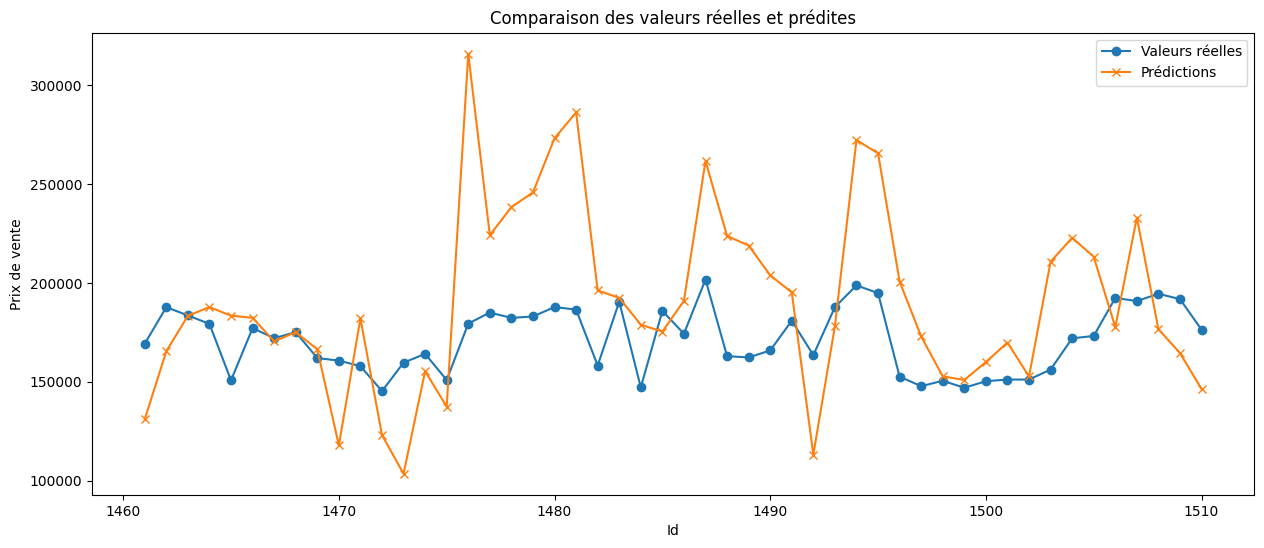

In [919]:
sample_comparison = comparison.head(50)  # Prenez un échantillon si nécessaire

plt.figure(figsize=(15, 6))
plt.plot(sample_comparison["Id"], sample_comparison["SalePrice_true"], label="Valeurs réelles", marker="o")
plt.plot(sample_comparison["Id"], sample_comparison["SalePrice_pred"], label="Prédictions", marker="x")
plt.title("Comparaison des valeurs réelles et prédites")
plt.xlabel("Id")
plt.ylabel("Prix de vente")
plt.legend()
plt.show()


In [920]:
# Définir une tolérance en pourcentage (exemple : 10% d'erreur tolérée)
tolerance = 0.1

# Calculer le pourcentage d'erreur relatif
relative_errors = np.abs(y_val - y_pred) / y_val

# Calculer le pourcentage de succès
success_rate = np.sum(relative_errors <= tolerance) / len(y_val) * 100

print(f"Pourcentage de prédictions réussies (erreur <= {tolerance * 100}%): {success_rate:.2f}%")


Pourcentage de prédictions réussies (erreur <= 10.0%): 74.13%
